# Movie Market Research

#### API Loading

In [13]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import seaborn as sns

In [14]:
# iterate through API requests. Records are stored in 'collected_data'
# this cell takes approximately 5 minutes to run

collected_data = []

for i in range(1,500,1):
    request_string = "https://api.themoviedb.org/3/discover/movie?api_key=afc7201593c1f2fc08c24eec64fabc88&language=en-US&sort_by=popularity.desc&include_adult=false&include_video=false&primary_release_date.lte=2019-12-30&primary_release_date.gte=2000-01-01&page="+str(i)
    data = requests.get(request_string)
    data = data.json()['results']
    for item in data:
        collected_data.append(item)

In [15]:
#load data into dataframe
df = pd.DataFrame(collected_data)

In [16]:
# The 'discover' API is missing budget, revenue, imdb_id, and runtime
# these can be pulled from the 'movie' API call. this cell prepares for the next for loop to pull this required data
budget = []
imdb_id = []
revenue = []
runtime = []
production_companies = []
production_countries = []
genres = []

In [17]:
#create a list of tmdb-movie-ids to iterate through. each id will be used in its own API call
#for each movie_id defined above, call API to to retrieve budget, revenue, imdb_id, runtime.
#tmdb data structure isn't uniform. movie dictionaries do not necessarily have all keys.
#to get around this, we used try/except
#this cell takes about 30 minutes to run
movie_ids = list(df['id'])
for movie_id in movie_ids:
    request_string = "https://api.themoviedb.org/3/movie/"+str(movie_id)+"?api_key=afc7201593c1f2fc08c24eec64fabc88&language=en-US"
    data = requests.get(request_string)
    data = data.json()
    try:
        budget.append(data['budget'])
    except:
        budget.append(" ")
    try:
        imdb_id.append(data['imdb_id'])
    except:
        imdb_id.append(" ")
    try:
        revenue.append(data['revenue'])
    except:
        revenue.append(" ")
    try:
        runtime.append(data['runtime'])
    except:
        runtime.append(" ")
    try:
        production_companies.append(data['production_companies'])
    except:
        production_companies.append(" ")
    try:
        production_countries.append(data['production_countries'])
    except:
        production_countries.append(" ")
    try:
        genres.append(data['genres'])
    except:
        genres.append(" ")

In [18]:
# Finally append the new columns to the final DataFrame
df['budget']=budget
df['imdb_id']=imdb_id
df['runtime']= runtime 
df['production_companies']=production_companies
df['production_countries']=production_companies
df['genres']=genres
df['revenue']=revenue

In [19]:
#save raw API results to csv
df.to_csv('tmdb_raw.csv',index=False)

In [23]:
#load raw data from csv
df=pd.read_csv('tmdb_raw.csv')

In [24]:
# Separating our release date into year and month.
df['release_year'] = df['release_date'].apply(lambda x: int(x[0:4]))
df['release_month'] = df['release_date'].apply(lambda x: int(x[5:7]))
df.drop('release_date',axis= 1,inplace=True)

In [25]:
# Removing unnecessary information
df.drop(['poster_path','video','backdrop_path','adult','original_language','genre_ids','original_title'],axis=1,inplace=True)

#Rearranging columns with a more easy to read order.
new_col=[ 'id', 'title', 'imdb_id','genres','overview', 'budget', 'release_year','release_month','popularity', 'vote_count','vote_average','revenue', 'runtime','production_companies', 'production_countries']
df=df[new_col]
# Dropping irrelevant missing data 
to_drop=df[(df.production_companies==" ")|(df.imdb_id=='')].index#(df.revenue==0)|(df.budget==0)|(df.runtime.isna())].index
df.drop(to_drop,inplace=True)


# Unpacking dictionaries from strings
df.production_companies = [eval(key) for key in df.production_companies]
df.production_countries= [eval(key) for key in df.production_countries]
df.genres= [eval(key) for key in df.genres]

# Resetting the index to maintain cohesive rows.
df.reset_index(drop=True,inplace=True)

In [26]:
#convert revenue, runtime, budget to floats
df['revenue']=df.revenue.astype('float64')
df['runtime']=df.runtime.astype('float64')
df['budget']=df.budget.astype('float64')

In [27]:
# Exporting main DF so API is not needed to run.
df.to_csv('tmdb_master.csv',index=False)

## Asking Questions

#### Who are top production companies by movie output?

In [33]:
# Load DataFrame and assess values
companies_df=df.copy()
#companies_df.reset_index(drop=True,inplace=True)
companies_df.sort_values('popularity',ascending=False).head(5)

,id,title,imdb_id,genres,overview,budget,release_year,release_month,popularity,vote_count,vote_average,revenue,runtime,production_companies,production_countries
0,475557,Joker,tt7286456,"[{'id': 80, 'name': 'Crime'}, {'id': 53, 'name...","During the 1980s, a failed stand-up comedian i...",55000000.0,2019,10,91.270,14356,8.2,1.074251e+09,122.0,"[{'id': 9993, 'logo_path': '/2Tc1P3Ac8M479naPp...","[{'id': 9993, 'logo_path': '/2Tc1P3Ac8M479naPp..."
1,299536,Avengers: Infinity War,tt4154756,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",As the Avengers and their allies have continue...,300000000.0,2018,4,80.814,19360,8.3,2.046240e+09,149.0,"[{'id': 420, 'logo_path': '/hUzeosd33nzE5MCNsZ...","[{'id': 420, 'logo_path': '/hUzeosd33nzE5MCNsZ..."
3,271110,Captain America: Civil War,tt3498820,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...","Following the events of Age of Ultron, the col...",250000000.0,2016,4,73.550,16653,7.4,1.153296e+09,147.0,"[{'id': 420, 'logo_path': '/hUzeosd33nzE5MCNsZ...","[{'id': 420, 'logo_path': '/hUzeosd33nzE5MCNsZ..."
2,27205,Inception,tt1375666,"[{'id': 28, 'name': 'Action'}, {'id': 878, 'na...","Cobb, a skilled thief who commits corporate es...",160000000.0,2010,7,70.987,26863,8.3,8.255328e+08,148.0,"[{'id': 923, 'logo_path': '/5UQsZrfbfG2dYJbx8D...","[{'id': 923, 'logo_path': '/5UQsZrfbfG2dYJbx8D..."
7,122917,The Hobbit: The Battle of the Five Armies,tt2310332,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",Immediately after the events of The Desolation...,250000000.0,2014,12,69.188,10138,7.3,9.560198e+08,144.0,"[{'id': 174, 'logo_path': '/IuAlhI9eVC9Z8UQWOI...","[{'id': 174, 'logo_path': '/IuAlhI9eVC9Z8UQWOI..."


In [34]:
# Creating a necessary functions
#Function 1
def namelist(cell):
    """
    namelist(string)
    
    This function takes in a cell and returns the unique names of the cells dictionary.
    """
    name_list=[]
    for i in cell:
        name_list.append(i['name'])
    return name_list


#Function 2
def list_to_dic(column,df,var='none'):
    """
    list_to_dic(string,dataframe)
    
    list_to_dic takes in the column that we want to create a dictionary that counts the repetition of values for 
    said word.
    list_to_dic creates a column in the provided DataFrame with the list of unique values of said column string,
    then it evaluates the string and teruns a dictionary list with all unique words and their count for the column.
    
    if variable is provided it will return a requested variable from the list_to_dic function
    """

    
    column_name=column+'_list'
    df[column_name]=df[column].apply(namelist)
    company_list=list(df[column_name])
    dup_list=[]
    
    if var=='unique_list':
        for a in company_list:
            for i in a:
                dup_list.append(i)
        unique_list=list(set(dup_list))
        return unique_list
    else:
        for a in company_list:
            for i in a:
                dup_list.append(i)
        unique_list=list(set(dup_list))
    company_dictionary={}
    
    for company in unique_list:
        company_dictionary[company]=0
    
    for company in dup_list:
        company_dictionary[company]=company_dictionary[company]+1
    if var=='dictionary':
        return company_dictionary

In [35]:
# Using our function to create a list of dictionarys with our unique companies
company_dictionary= list_to_dic('production_companies',companies_df, "dictionary")

In [37]:
# Creating our DataFrame ready for Plotting
companies_df=pd.DataFrame(company_dictionary.items(),  columns=['Name', 'Count'])
top=companies_df.sort_values('Count', ascending=False).head(20)

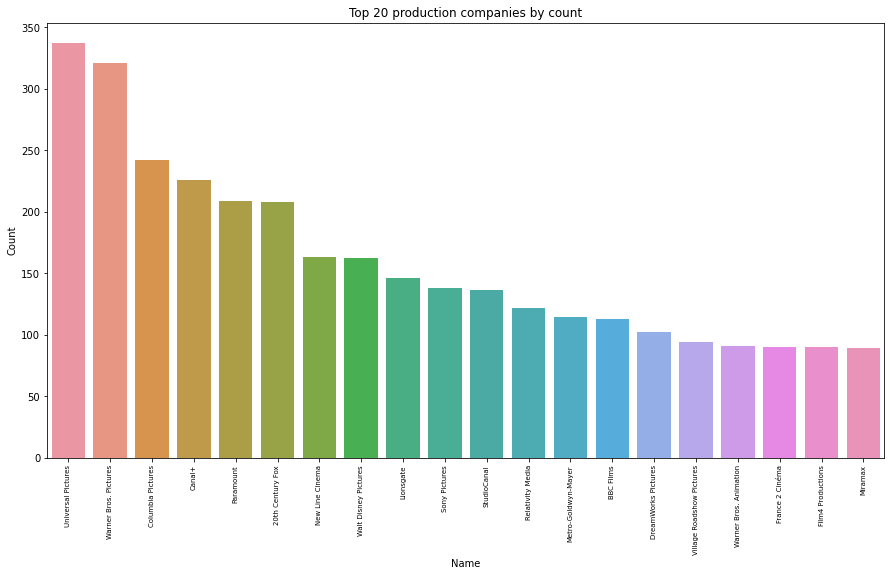

In [38]:
# Final Plot
x=top['Name']
y=top['Count']

fig,ax=plt.subplots(figsize=(15,8))
comp_bar=sns.barplot(x,y)
comp_bar.set(title='Top 20 production companies by count')
comp_bar.set_xticklabels(comp_bar.get_xticklabels(), rotation=90,fontsize='x-small');



--Through our analysis the dataset, 20 of the above companies lead the movie industry. Standing out would be the household names Universal Pictures and Warner Bros. Pictures.


#### Who are the top 20 production companies by mean box office revenue?

In [39]:
# Loading our master file and creating a DataFrame to work with
revenue_df=df.copy()

In [40]:
#Dropping irrelevant missing data 
to_drop=revenue_df[(revenue_df.revenue==0)|(revenue_df.budget==0)].index
revenue_df.drop(to_drop,inplace=True)

In [41]:
# Getting our unique list
unique_list= list_to_dic('production_companies',revenue_df,'unique_list')
unique_list=sorted(unique_list)

In [42]:
# Creating our list lenght and mean revenue columns.
revenue_df.reset_index(drop=True,inplace=True)
revenue_df['list_length']=revenue_df.production_companies_list.apply(lambda x: len(x))
revenue_df['mean_revenue']= revenue_df.revenue/revenue_df.list_length

In [43]:
# Creating a list where we calculate the mean based on our totlal companies and the total revenue
company_revenue_mean=[]
for company in unique_list:
    count=0
    total=0
    for i in range(len(revenue_df.production_companies_list)):
        if company in revenue_df.production_companies_list[i]:
            total+= revenue_df.mean_revenue[i]
            count+=1
    company_revenue_mean.append(total/count)

In [44]:
#Creating the mean table 
company_revenue_mean=[x/1000 for x in company_revenue_mean]
mean_company=pd.DataFrame(company_revenue_mean,unique_list)
mean_company.reset_index(inplace=True)
mean_company.columns=['company','mean']
mean_company.sort_values('mean',ascending=False,inplace=True)
mean_company.reset_index(drop=True, inplace=True)

In [45]:
mean_company.head(2)

,company,mean
0,Marvel Studios,733176.693000
1,Truenorth Productions,689407.874667


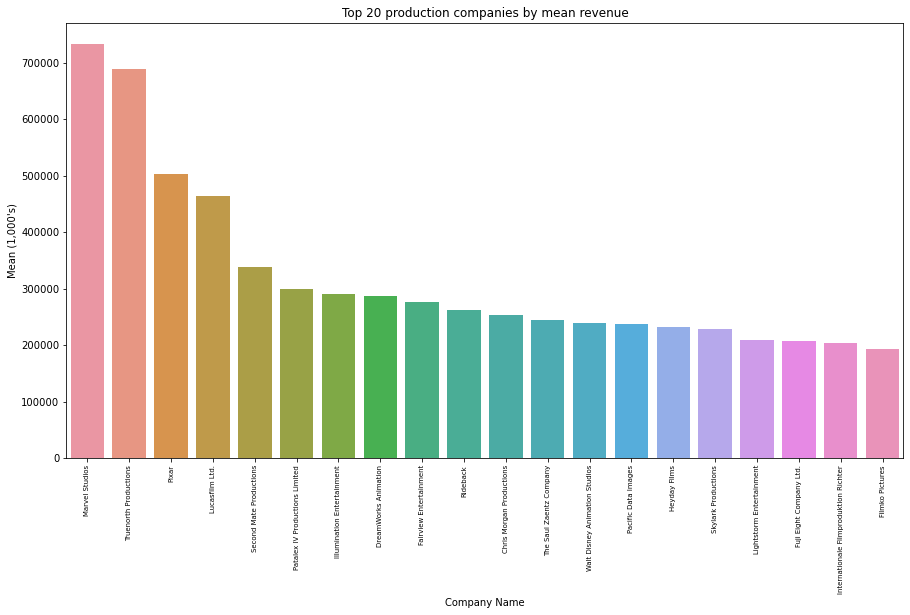

In [46]:
# plotting our Top 20 Production Companies 
x=mean_company['company'].head(20)
y=mean_company['mean'].head(20)

fig,ax=plt.subplots(figsize=(15,8))
comp_bar=sns.barplot(x,y)
comp_bar.set(title='Top 20 production companies by mean revenue', ylabel='Mean (1,000\'s)',xlabel='Company Name')
comp_bar.set_xticklabels(comp_bar.get_xticklabels(), rotation=90,fontsize='x-small');


--Standing out in the top 3 would be Marvel Studios, Truenorth Productions and Pixar providing with well kown box office blockbusters.

#### What is the market saturation of generes?

In [58]:
# Loading our master and creating our DataFrame
genre_df= df.copy()

In [59]:
unique_list=list_to_dic('genres',genre_df,'unique_list')

In [60]:
unique_list

['Drama',
 'War',
 'History',
 'Thriller',
 'Western',
 'Science Fiction',
 'Mystery',
 'Family',
 'Action',
 'Comedy',
 'Adventure',
 'Horror',
 'Documentary',
 'Crime',
 'Music',
 'TV Movie',
 'Animation',
 'Romance',
 'Fantasy']

In [61]:
# Createing new columns to evaluate what genres were used in each movies.
for genre in unique_list:
    new_col=genre
    genre_df[new_col]=genre_df['genres_list'].apply(lambda x: 1 if genre in x else 0 )

In [62]:
# Grouping our genres per year to count the genres released and arranging our table for plotting.
year_groupby = genre_df.groupby(['release_year']).sum()
year_groupby.drop(year_groupby.iloc[:,0:8],axis=1,inplace=True)
year_groupby

,Drama,War,History,Thriller,Western,Science Fiction,Mystery,Family,Action,Comedy,Adventure,Horror,Documentary,Crime,Music,TV Movie,Animation,Romance,Fantasy
release_year,,,,,,,,,,,,,,,,,,,
2000,116,8,3,67,3,27,19,37,52,109,32,29,6,44,11,4,26,50,28
2001,106,8,11,69,3,27,23,30,59,105,40,28,3,46,6,9,22,65,25
2002,132,10,9,82,1,23,34,42,66,115,46,34,9,45,10,4,27,58,23
2003,115,8,10,69,4,30,23,46,73,117,45,29,9,41,13,6,30,50,26
2004,151,9,10,70,5,39,32,39,70,121,52,40,7,38,15,6,31,63,31
2005,174,8,13,90,3,22,31,58,71,135,55,55,17,49,10,8,34,65,36
2006,193,11,17,115,3,37,35,71,77,153,57,64,16,50,14,17,49,67,44
2007,203,5,11,120,4,32,32,46,83,134,48,68,16,63,13,13,38,82,45
2008,202,15,20,104,3,48,28,67,93,160,67,59,17,54,18,12,43,82,36


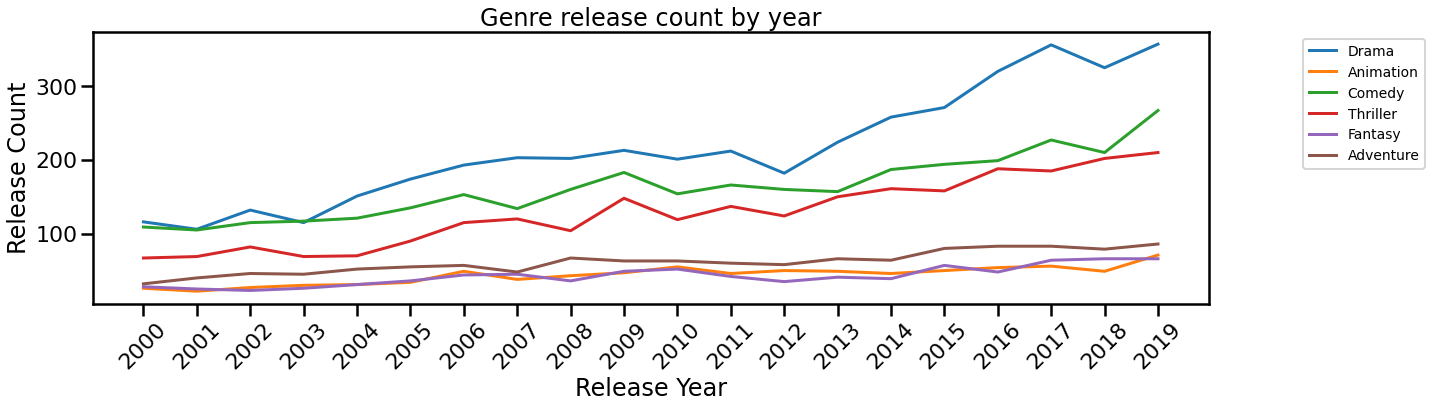

In [63]:
# Plotting our final DafaFrame
plt.figure(figsize=(20,5))
sns.set_context('poster')
line=sns.lineplot(data=year_groupby[['Drama','Animation','Comedy','Thriller','Fantasy','Adventure']],dashes=False)
line.set(xlabel='Release Year',ylabel='Release Count',title='Genre release count by year')
line.legend(bbox_to_anchor=(1.2, 1), loc='upper right',fontsize='xx-small')
plt.xticks(ticks=range(2000,2020),labels= range(2000,2020))
line.set_xticklabels(line.get_xticklabels(), rotation=45);

plt.show()

-- We find that the trend throught the years is that Drama, Comedy and Thriller have saturated the market the most. 

#### What is the profit distribution by genre?

In [64]:
#drop rows where revenue or budget equal 0.
to_drop=genre_df[(df.revenue==0)|(df.budget==0)].index
genre_df.drop(to_drop,inplace=True)

In [65]:
#create new column "Profit"
genre_df['Profit']= genre_df['revenue']- genre_df['budget']

In [66]:
#creating columns for each genre, with boolean values depending if the genre appears in the "genres_list_ column"
for genre in unique_list:
    new_col=genre
    genre_df[new_col]=genre_df['Profit']*genre_df['genres_list'].apply(lambda x: 1 if genre in x else 0 )

In [67]:
#dividing our results to be more legible while plotting
main_list=[]
for genre in unique_list:
    variable=[]
    variable=list(genre_df[genre])
    variable=[x/1000000 for x in variable if x!=0 ]
    main_list.append(variable)

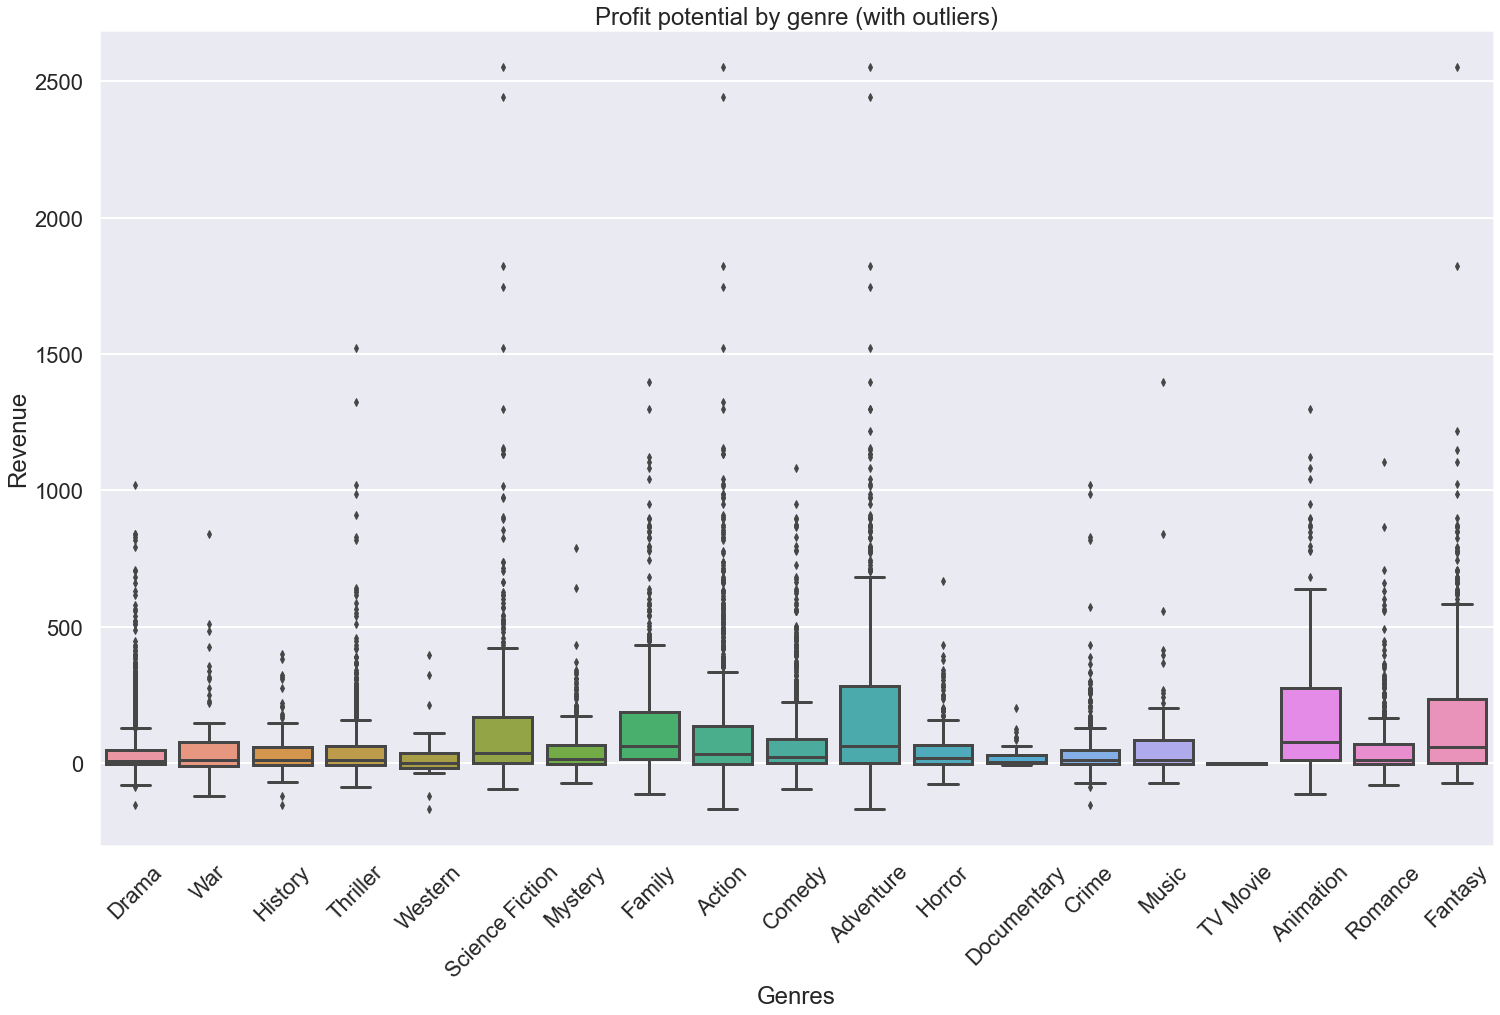

In [68]:
#plotting our figure
plt.figure(figsize=(25,15))
sns.set_style('darkgrid')
sns.set_context('poster')
boxplot=sns.boxplot(data=main_list)
boxplot.set(xlabel='Genres',ylabel='Revenue',title='Profit potential by genre (with outliers)')
plt.xticks(ticks=range(0,19),labels=unique_list)
boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=45);

plt.show()

--Suprisingly we can see that Adventure, Action and Animation have had the biggest margin of profit.

#### What is the profit distribution by genre without outliers?

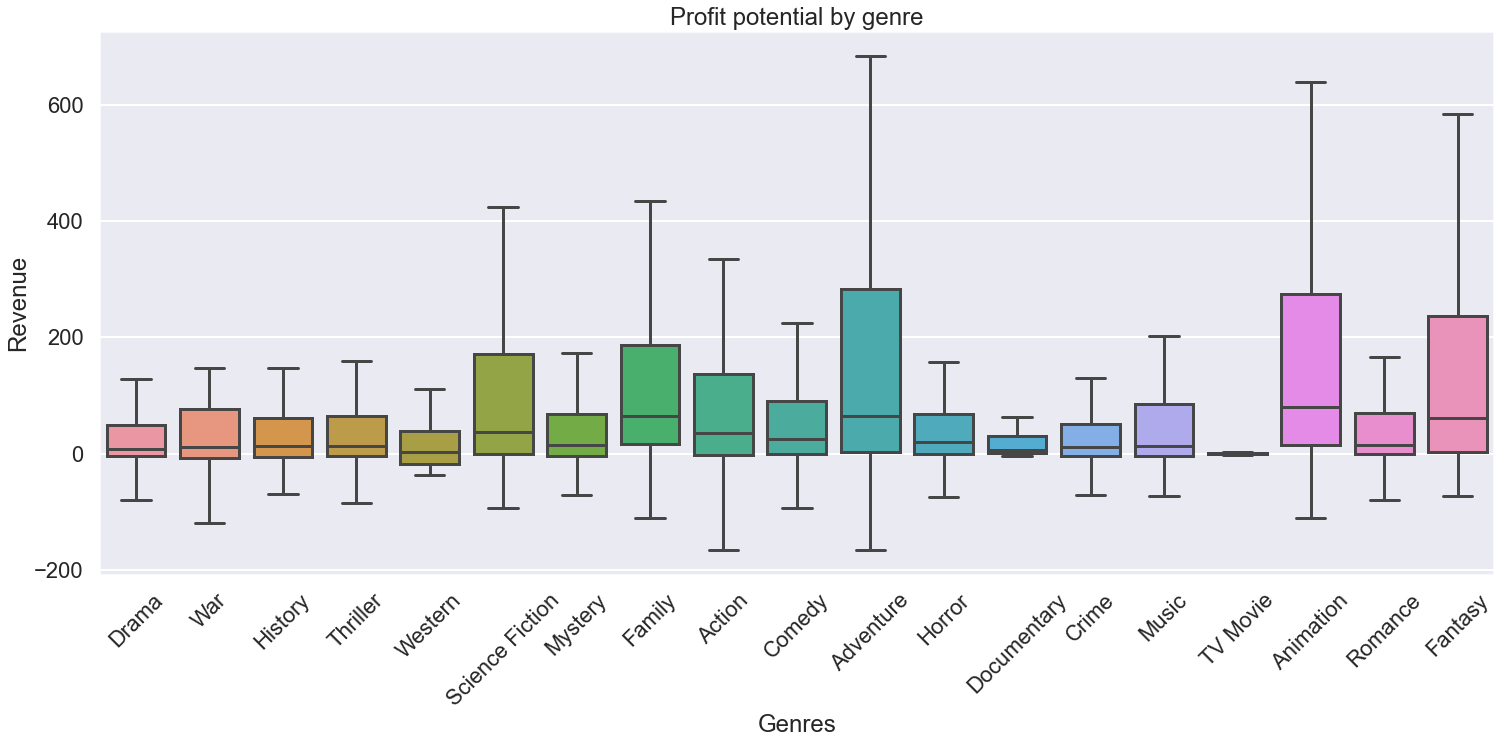

In [69]:
#plotting figure without outliers
plt.figure(figsize=(25,10))
sns.set_context('poster')
boxplot2=sns.boxplot(data=main_list,showfliers=False)
boxplot2.set(xlabel='Genres',ylabel='Revenue',title='Profit potential by genre')
plt.xticks(ticks=range(0,19),labels=unique_list)
boxplot2.set_xticklabels(boxplot2.get_xticklabels(), rotation=45);
plt.show()

-- And by removing the outliers the data becomes more clear.

#### What are the most popular months to release a movie?

In [76]:
#loading a new copy of dataframe
month_df=df.copy()

In [77]:
#creating our new column and unique list
unique_list=list_to_dic('genres',month_df,'unique_list')

In [78]:
# Createing new columns to evaluate what genres were used in each movies.
for genre in unique_list:
    new_col=genre
    month_df[new_col]=month_df['genres_list'].apply(lambda x: 1 if genre in x else 0 )

In [79]:
#summing up totals by realease_month
month_groupby = month_df.groupby(['release_month']).sum()

In [80]:
#dropping unneccessary data
month_groupby_sum=month_groupby.drop(month_groupby.iloc[:,0:8],axis=1)

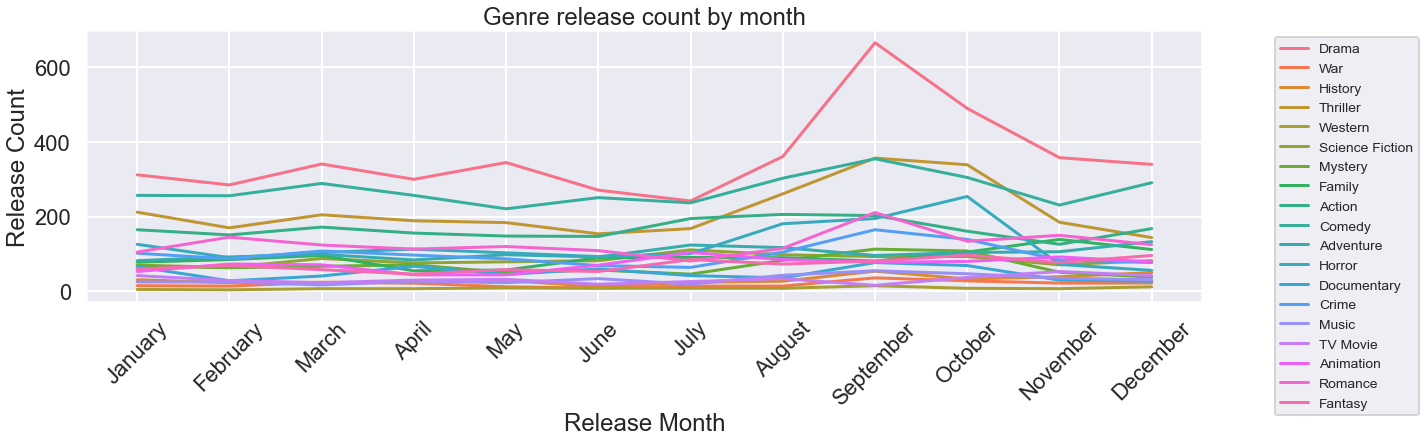

In [81]:
#plotting our figure
plt.figure(figsize=(20,5))
line2=sns.lineplot(data=month_groupby_sum, dashes=False)

line2.legend(bbox_to_anchor=(1.2, 1), loc='upper right', fontsize='xx-small')

line2.set(xlabel='Release Month',ylabel='Release Count',title='Genre release count by month')


plt.xticks(range(1,13),labels=['January','February','March','April','May','June','July','August','September','October','November','December'])
line2.set_xticklabels(line2.get_xticklabels(), rotation=45);




plt.show()

-- While unclear based on the above chart there is a tendency to release movies in September.

#### What is a Dump Month?

In [82]:
#creating our month total column (aggregate of all genres)
sum_list=[]
for i in range(0,12): 
    sum_list.append(month_groupby_sum.iloc[i].sum())
month_groupby_sum['month_total']=sum_list

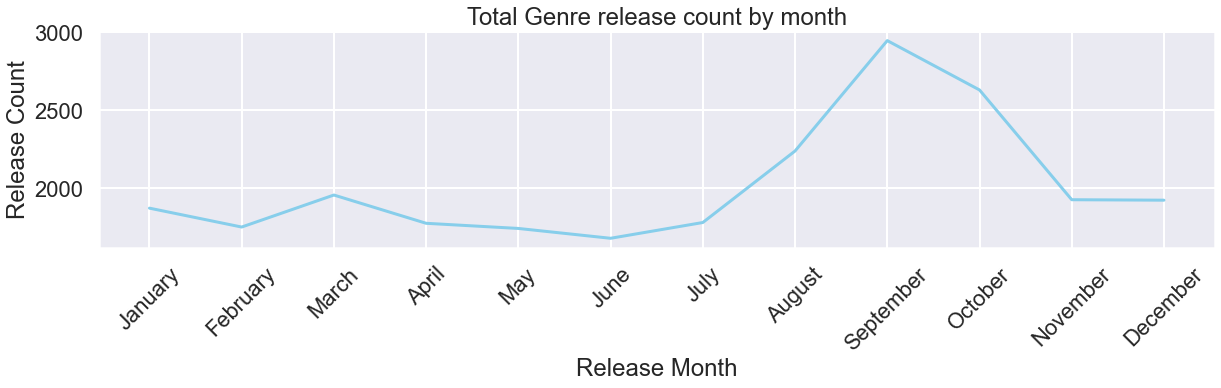

In [83]:
#plotting our figure
plt.figure(figsize=(20,4))
line2=sns.lineplot(data=month_groupby_sum['month_total'], dashes=False, color='skyblue')


line2.set(xlabel='Release Month',ylabel='Release Count',title='Total Genre release count by month')


plt.xticks(range(1,13),labels=['January','February','March','April','May','June','July','August','September','October','November','December','Month Total'])
line2.set_xticklabels(line2.get_xticklabels(), rotation=45);




plt.show()

-- By aggregating all genre releases together this trend of releasing in September becomes even more clear! In fact, in the movie industry, September is known as a Dump Month characterized by reduced consumer spending limits. As such, production companies typically unload or release the movies that are not expected to generate much revenue.

#### What is the distribution of runtime for the most profitable genres?

In [84]:
#loading a new copy of the dataframe
histogram_df=df.copy()

In [85]:
#creating a unique list of genres
unique_list=list_to_dic('genres',histogram_df,'unique_list')

In [86]:
# Createing new columns to evaluate what genres were used in each movies.
for genre in unique_list:
    new_col=genre
    histogram_df[new_col]=histogram_df['genres_list'].apply(lambda x: 1 if genre in x else 0 )

In [87]:
#dropping null values before evaluating
to_drop=histogram_df[(histogram_df.runtime.isna())].index
histogram_df.drop(to_drop,inplace=True)

In [88]:
#creating new genre columns. Values are boolean and indicate if genre appears in "genre_list" column
for genre in unique_list:
    histogram_df[genre]=(histogram_df['runtime'])*(histogram_df['genres_list'].apply(lambda x: 1 if genre in x else 0 ))

In [89]:
#creating unique lists for top three genres
fantasy=list(histogram_df['Fantasy'])
animation=list(histogram_df['Animation'])
adventure=list(histogram_df['Adventure'])

In [90]:
#removing zeros from the above lists
fantasy=[ x for x in fantasy if x!=0]
animation=[ x for x in animation if x!=0]
adventure=[ x for x in adventure if x!=0]

[Text(0.5, 1.0, 'Adventure')]

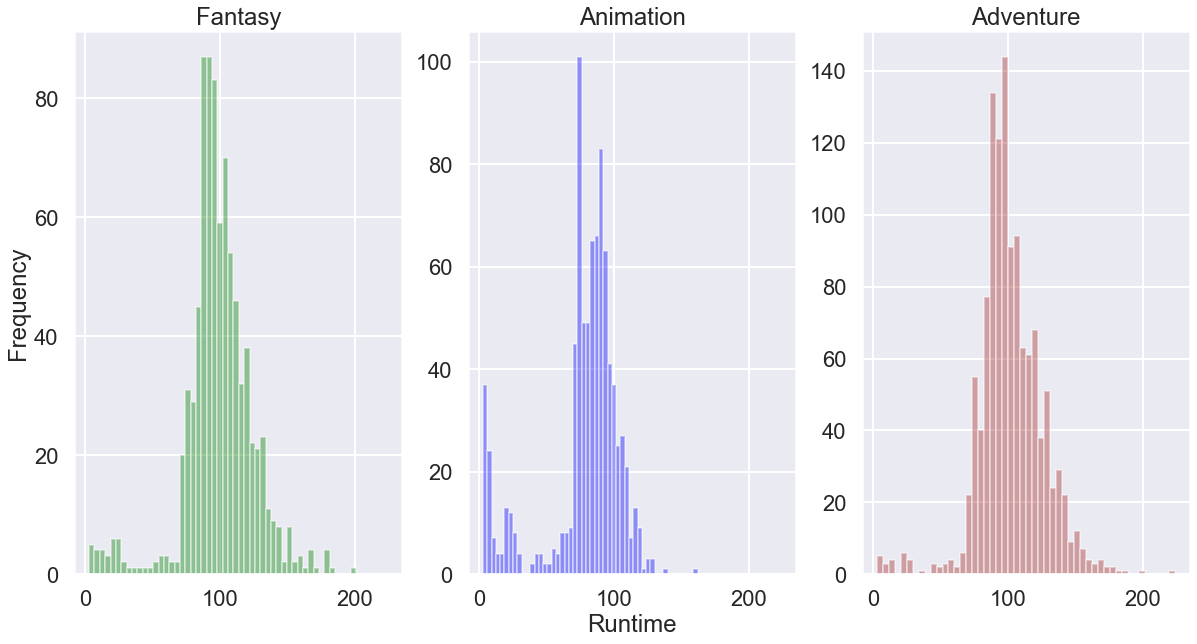

In [91]:
#plotting our figure
sns.set_style('darkgrid')
f,axes=plt.subplots(1,3, figsize=(20,10), sharex= True)
sns.distplot(fantasy,bins=50,color= 'green',kde=False,ax=axes[0])
sns.distplot(animation,bins=50,color = 'blue',kde=False,ax=axes[1])
sns.distplot(adventure,bins=50,color = 'brown',kde=False,ax=axes[2])
axes[0].set(ylabel='Frequency',title='Fantasy')
axes[1].set(xlabel='Runtime',title='Animation')
axes[2].set(title='Adventure')

-- For the most popular genres it is common to stick to between 90 to 100 minutes per runtime in the film.

### Recomendations 

Competition:
* Investigate the operations of production companies such as Universal Pictures and Warner Brothers to optimize your movie production output. 
* Focus on developing large franchises like those owned by Marvel and Lucasfilms in order to maximize total revenue at the box office.

Genres:
* Avoid genres like Drama, Comedy, and Thriller as these are highly saturated.
* Focus on developing Fantasy, Adventure, and Animation movies as these return the highest profit.

Release Month:
* Avoid releasing films in “Dump Months” such as September, as you will have increased competition.

Runtime:
* Based on our analysis, the typical Fantasy, Animation, and Adventure genres are typically 90-100 minutes in duration.